In [1]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
from NVcenter.mitigation import *
plt.style.use('NVcenter-default')

import qutip as q
import numpy as np

hada = 1/np.sqrt(2) * q.Qobj([[1,1], [1,-1]])
U_theta = q.Qobj( [[0.5-0.5j, 0.5+0.5j], [-0.5+0.5j, 0.5+0.5j]] )

## Create Data

Period: 11.892020451590717


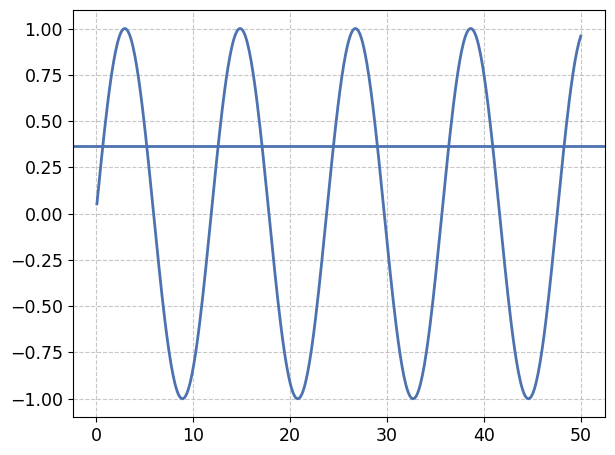

In [201]:
T2 = 50e-6
T1 = 100e-6
Bz = 3e-6 # T 

xm, xp = q.sigmax().eigenstates()[1]
xp, xm = xp * xp.dag(), xm * xm.dag()
ym, yp = q.sigmay().eigenstates()[1]
yp, ym = yp * yp.dag(), ym * ym.dag()
zp, zm = q.sigmaz().eigenstates()[1]
zm, zp = zp * zp.dag(), zm * zm.dag()

hada = 1/np.sqrt(2) * q.Qobj([[1,1], [1,-1]])
U_theta = q.Qobj( [[0.5-0.5j, 0.5+0.5j], [-0.5+0.5j, 0.5+0.5j]] )
hada_phase = U_theta * hada
#   hada, hada_phase = q.qeye(2), q.qeye(2)

init_states = [hada * dm * hada for dm in [zp, zm, xp, yp]]
# init_states = [hada * dm * hada for dm in [xp, xm, yp, ym, zp, zm]]

delta = (CONST['gamma_e'] * Bz)
H = q.Qobj([[0,0], [0,delta]])
c_ops = []#[1/np.sqrt(2*T2) * q.sigmaz(), np.sqrt(1/T1) * q.sigmap()]
times = np.linspace(0, 50e-6, 500)

states = []
for init_state in init_states:
    rho0 = init_state
    result = q.mesolve(H, rho0, times, c_ops).states
    result = [hada_phase * dm * hada_phase for dm in result]
    states.append(result)

pauli = True
if pauli:
    sigmax = np.array( [[q.expect(dm, q.sigmax()).real for dm in row] for row in states])
    sigmay = np.array( [[q.expect(dm, q.sigmay()).real for dm in row] for row in states])
    sigmaz = np.array( [[q.expect(dm, q.sigmaz()).real for dm in row] for row in states])
    miri_list = np.array([sigmax, sigmay, sigmaz])

else:
    pop0 = np.array( [[q.expect(dm, q.fock_dm(2, 0)).real for dm in row] for row in states] )
    pop1 = np.array( [[q.expect(dm, q.fock_dm(2, 1)).real for dm in row] for row in states] )
    miri_list = np.array([pop0, pop1])
    
miri_list = np.transpose(miri_list, (1, 0, 2))
np.save("Lindblad_test6.npy", miri_list)
# miri_list = np.load("Lindblad_test1.npy")
plt.plot(times[1:]*1e6, miri_list[0,2,1:])
plt.axhline(y=1/np.e)
print('Period:', abs(2*np.pi/delta)*1e6)

## Execution

In [2]:
i = 50
miri_list = np.load("Lindblad_test1.npy")
times = np.linspace(0, 50e-6, 500)

miri_list = miri_list[:,:,1:]
PTM_list = construct_PTM(miri_list)
PTM = PTM_list[:,:,i]
init_rho = q.fock_dm(2,0)

print( is_decomposition_successful(PTM, init_rho) )
print( is_circuit_successful(PTM, init_rho) )

True
True


In [3]:
choi = q.Qobj([[1,0,0,0], [0,0,0,0], [0,0,1,0], [0,0,0,0]])
get_circuit_input(choi)

(Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
 Qobj data =
 [[0.00000000e+00+0.70710678j 0.00000000e+00-0.70710678j]
  [0.00000000e+00-0.70710678j 1.11022302e-16-0.70710678j]],
 Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
 Qobj data =
 [[ 0.70710678  0.70710678]
  [-0.70710678  0.70710678]],
 np.float64(1.5707963267948966),
 np.float64(1.5707963267948966))

### test template

In [5]:
init_rho = q.fock_dm(2,0)
times = np.linspace(0, 50e-6, 500)

# without noise
miri_list = np.load("Lindblad_test3.npy")
perfect_rho_list = calc_noisy_rho_list(miri_list, init_rho)

# with noise
miri_list = np.load("Lindblad_test2.npy")
noisy_rho_list = calc_noisy_rho_list(miri_list, init_rho)

# mitigated noise
miri_list = np.load("Lindblad_test1.npy")
PTM_list = construct_PTM(miri_list)

# hadamard
hada = 1/np.sqrt(2) * q.Qobj([[1,1], [1,-1]])
U_theta = q.Qobj( [[0.5-0.5j, 0.5+0.5j], [-0.5+0.5j, 0.5+0.5j]] )
hada_phase = hada
hada, hada_phase = q.qeye(2), U_theta * q.qeye(2)

mitigated_rho_list = []
timesteps = miri_list.shape[-1]
for i in range(timesteps-1):
    PTM = PTM_list[:,:,i]
    noisy_rho = noisy_rho_list[i]
    p, choi_p1, choi_p2, choi_m1, choi_m2 = get_decomposition(PTM)
    mitigated_rho = apply_circuits(p, choi_p1, choi_p2, choi_m1, choi_m2, noisy_rho, init_gate=hada, end_gate=hada_phase)
    mitigated_rho_list.append(mitigated_rho)

Expected Period:  178.38030677386078 us


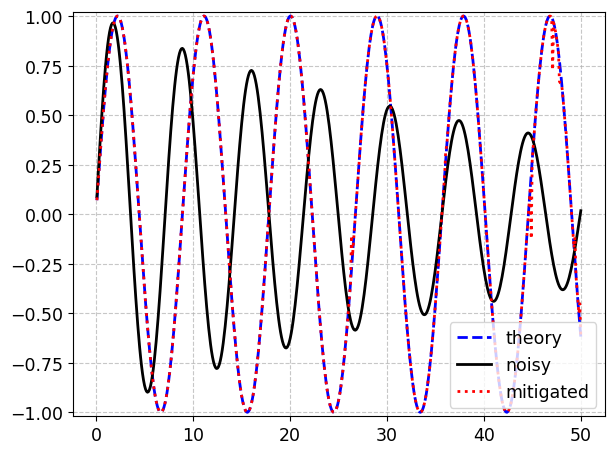

In [6]:
vals = [q.expect(perfect_rho, q.sigmaz()) for perfect_rho in perfect_rho_list]
plt.plot(times[1:]*1e6, vals, label='theory', color='b', ls='--')

vals = [q.expect(noisy_rho, q.sigmaz()) for noisy_rho in noisy_rho_list]
plt.plot(times[1:]*1e6, vals, label='noisy', color='k')

vals = [q.expect(mitigated_rho, q.sigmaz()) for mitigated_rho in mitigated_rho_list]
plt.plot(times[1:]*1e6, vals, label='mitigated', color='r', ls=':')

plt.ylim(-1.02, 1.02)
plt.legend()
print("Expected Period: ", abs(2*np.pi/(CONST['gamma_e']*200e-9))*1e6, "us")

### test 3

In [7]:
init_rho = q.fock_dm(2,0)
times = np.linspace(0, 50e-6, 500)

# without noise
miri_list = np.load("export//dwyer_density_16nm_thermal//no_bath_200nT_Pauli.npy")
perfect_rho_list = calc_noisy_rho_list(miri_list, init_rho, use_old_construct_PTM=True)

# with noise
miri_list = np.load("export//dwyer_density_16nm_thermal//full_bath_200nT_Pauli.npy")
noisy_rho_list = calc_noisy_rho_list(miri_list, init_rho, use_old_construct_PTM=True)

# mitigated noise
miri_list = np.load("export//dwyer_density_16nm_thermal//full_bath_0nT_Pauli.npy")
PTM_list = old_construct_PTM(miri_list)

# hadamard
hada = 1/np.sqrt(2) * q.Qobj([[1,1], [1,-1]])
U_theta = q.Qobj( [[0.5-0.5j, 0.5+0.5j], [-0.5+0.5j, 0.5+0.5j]] )
hada_phase = hada
hada, hada_phase = q.qeye(2), U_theta * q.qeye(2)

mitigated_rho_list = []
timesteps = miri_list.shape[-1]
for i in range(timesteps-1):
    PTM = PTM_list[:,:,i]
    noisy_rho = noisy_rho_list[i]
    p, choi_p1, choi_p2, choi_m1, choi_m2 = get_decomposition(PTM)
    mitigated_rho = apply_circuits(p, choi_p1, choi_p2, choi_m1, choi_m2, noisy_rho, init_gate=hada, end_gate=hada_phase)
    mitigated_rho_list.append(mitigated_rho)

Expected Period:  178.38030677386078 us


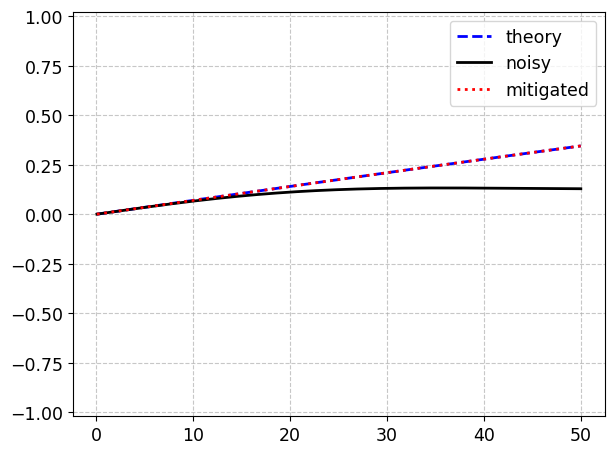

In [8]:
vals = [q.expect(perfect_rho, q.sigmaz()) for perfect_rho in perfect_rho_list]
plt.plot(times[1:]*1e6, vals, label='theory', color='b', ls='--')

vals = [q.expect(noisy_rho, q.sigmaz()) for noisy_rho in noisy_rho_list]
plt.plot(times[1:]*1e6, vals, label='noisy', color='k')

vals = [q.expect(mitigated_rho, q.sigmaz()) for mitigated_rho in mitigated_rho_list]
plt.plot(times[1:]*1e6, vals, label='mitigated', color='r', ls=':')

plt.ylim(-1.02, 1.02)
plt.legend()
print("Expected Period: ", abs(2*np.pi/(CONST['gamma_e']*200e-9))*1e6, "us")

### test 4

In [9]:
init_rho = q.fock_dm(2,0)
times = np.linspace(0, 50e-6, 500)

# without noise
miri_list = np.load("Lindblad_test6.npy")
perfect_rho_list = calc_noisy_rho_list(miri_list, init_rho)

# with noise
miri_list = np.load("Lindblad_test5.npy")
noisy_rho_list = calc_noisy_rho_list(miri_list, init_rho)

# mitigated noise
miri_list = np.load("Lindblad_test4.npy")
PTM_list = construct_PTM(miri_list)

# hadamard
hada = 1/np.sqrt(2) * q.Qobj([[1,1], [1,-1]])
U_theta = q.Qobj( [[0.5-0.5j, 0.5+0.5j], [-0.5+0.5j, 0.5+0.5j]] )
hada_phase = hada
hada, hada_phase = q.qeye(2), U_theta * q.qeye(2)

mitigated_rho_list = []
timesteps = miri_list.shape[-1]
for i in range(timesteps-1):
    PTM = PTM_list[:,:,i]
    noisy_rho = noisy_rho_list[i]
    p, choi_p1, choi_p2, choi_m1, choi_m2 = get_decomposition(PTM)
    mitigated_rho = apply_circuits(p, choi_p1, choi_p2, choi_m1, choi_m2, noisy_rho, init_gate=hada, end_gate=hada_phase)
    mitigated_rho_list.append(mitigated_rho)

Expected Period:  178.38030677386078 us


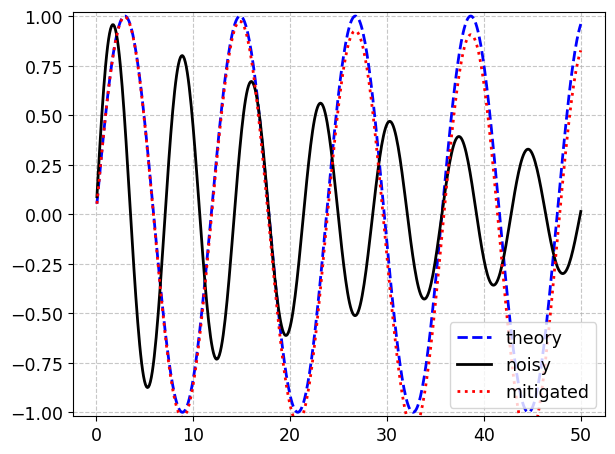

In [10]:
vals = [q.expect(perfect_rho, q.sigmaz()) for perfect_rho in perfect_rho_list]
plt.plot(times[1:]*1e6, vals, label='theory', color='b', ls='--')

vals = [q.expect(noisy_rho, q.sigmaz()) for noisy_rho in noisy_rho_list]
plt.plot(times[1:]*1e6, vals, label='noisy', color='k')

vals = [q.expect(mitigated_rho, q.sigmaz()) for mitigated_rho in mitigated_rho_list]
plt.plot(times[1:]*1e6, vals, label='mitigated', color='r', ls=':')

plt.ylim(-1.02, 1.02)
plt.legend()
print("Expected Period: ", abs(2*np.pi/(CONST['gamma_e']*200e-9))*1e6, "us")